In [187]:
from textwrap import indent

from IPython.display import Javascript

from liblet import ANTLR, AnnotatedTreeWalker, Tree, pyast2tree, side_by_side

from operator import add, mul, truediv, sub

from operator import itemgetter


from fractions import Fraction


In [188]:
ArithmeticExpression = ANTLR(r"""
grammar arithmetic;
ignoblebug: expression;

file_ : expression EOF;



expression                                               // TODO: parentesizzazione semplice efficiente
   : (PLUS | MINUS)? (INTEGER|RATIONAL)                  # atomExpression
   | <assoc=right>expression POW expression              # powExpression
   | expression  FRACT  expression                       # FractExpression
   | (PLUS | MINUS) expression                           # unaryExpression
   | expression  (TIMES | DIV)  expression               # divProdExpression
   | expression  (PLUS | MINUS) expression               # addSubExpression
   | GRAPH_L_PAREN expression GRAPH_R_PAREN              # blockExpression
   | SUBEXP_L_PAREN expression SUBEXP_R_PAREN            # subExpression
   ;


INTEGER   
   : NUMBER 
   ;
   
RATIONAL
    : NUMBER FRACT NUMBER
    ;


   
NUMBER
   : ('0' .. '9') + ('.' ('0' .. '9') +)?
   ;   
   
GRAPH_L_PAREN : '(' ;
GRAPH_R_PAREN : ')' ;
SUBEXP_L_PAREN : '<' ;
SUBEXP_R_PAREN : '>' ;
PLUS   : '+' ;
MINUS  : '-' ;
TIMES  : 'x' ;
DIV    : ':' ;
POINT  : '.' ;
POW    : '^' ;
FRACT  : '/' ;

WS
   : [ \r\n\t] + -> skip
   ;
   

""")

ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2


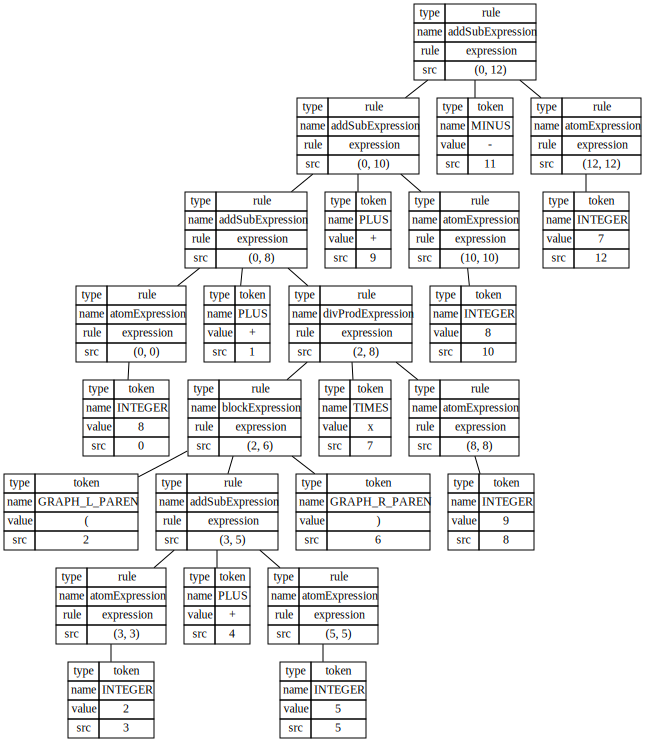

In [189]:
expr = """
1 + (2 x ((3 + 4 : 2) + 5) x 6) - (7 + (1 + 8) : 3) x (9 : (2 + 1) + 2)
"""

expr = '8 + (2+5) x 9 + 8 - 7'


ptree = ArithmeticExpression.tree(expr, 'expression')
ptree

In [251]:
arith2ast = AnnotatedTreeWalker('name')


PRIORITY = {
    'blockExpression' : 6,
    'fractExpression' : 5,
    'powExpression' : 4,
    'unaryExpression' : 3,
    'divProdExpression' : 2,
    'addSubExpression' : 1
}

@arith2ast.register
def RATIONAL(visit, ptree):
    return Fraction(ptree.root['value'])

@arith2ast.register
def INTEGER(visit, ptree):
    return int(ptree.root['value'])


@arith2ast.register
def atomExpression(visit, ptree):
    child = ptree.children[0]
    #return Tree({'type': child.root['name'].lower(), 'value': int(child.root['value'])}, []), 0
    grade = 0
    return Tree({'type': 'atomExpression', 'value': visit(child), 'grade': grade}, []), 0

@arith2ast.register
def addSubExpression(visit, ptree):
    left, op, right = ptree.children
    left, left_priority = visit(left)
    right, right_priority = visit(right)
    
    grade = max(left.root['grade'], right.root['grade'])
    priority = max(left_priority, right_priority, PRIORITY['addSubExpression'])

    return Tree({'type': 'addSubExpression', 'op': op.root['value'], 'priority': priority, 'grade': grade}, [left, right]), priority


@arith2ast.register
def divProdExpression(visit, ptree):
    left, op, right = ptree.children
    left, left_priority = visit(left)
    right, right_priority = visit(right)
    
    grade = max(left.root['grade'], right.root['grade'])
    priority = max(left_priority, right_priority, PRIORITY['divProdExpression'])    

    return Tree({'type': 'divProdExpression', 'op': op.root['value'], 'priority': priority, 'grade': grade}, [left, right]), priority


@arith2ast.register
def powExpression(visit, ptree):
    left, _, right = ptree.children
    left, left_priority = visit(left)
    right, right_priority = visit(right)
    
    grade = max(left.root['grade'], right.root['grade'])
    priority = max(left_priority, right_priority, PRIORITY['powExpression'])  
    
    return Tree({'type': 'powExpression', 'priority': priority, 'grade': grade}, [left, right]), priority


@arith2ast.register
def fractExpression(visit, ptree):
    left, _, right = ptree.children
    left, left_priority = visit(left)
    right, right_priority = visit(right)
    
    grade = max(left.root['grade'], right.root['grade'])
    priority = max(left_priority, right_priority, PRIORITY['fractExpression'])   
    
    return Tree({'type': 'fractExpression', 'priority': priority, 'grade': grade}, [left, right]), priority


@arith2ast.register
def blockExpression(visit, ptree):
    _, subexpr, _ = ptree.children
    subexpr, priority = visit(subexpr)
    
    grade = subexpr.root['grade'] + 1
    
    return Tree({'type': 'blockExpression', 'grade': grade}, [subexpr]), 0
    #depth = depth + 1
    #subexpr.root['depth'] = depth
    #return subexpr, depth
    

@arith2ast.register
def subExpression(visit, ptree):
    _, subexpr, _ = ptree.children
    return visit(subexpr)
    #depth = depth + 1
    #subexpr.root['depth'] = depth
    #return subexpr, depth
    



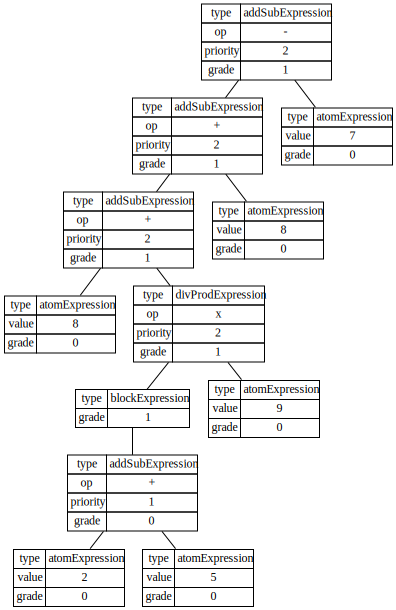

In [252]:
ast, _ = arith2ast(ptree)
ast

In [253]:
def src2ast(source):
    ast, _ = arith2ast(ArithmeticExpression.tree(source, 'expression'))
    return ast

Fraction(6, 3) + 1

Fraction(3, 1)

In [257]:
atw_eval = AnnotatedTreeWalker('type')

ARITH_OP = {
    '+' : add,
    '-' : sub,
    'x' : mul,
    ':' : Fraction,
    '/' : Fraction
}



def find_more_priority_child(ast):
    grades = [child.root['grade'] for child in ast.children]
    priorities = [child.root['priority'] if 'priority' in child.root else -1 for child in ast.children]
    
    item = max(grades)
    if item == 0:
        return priorities.index(max(priorities))
    return grades.index(item)


def is_calculable(ast):
    return ast.root['type'] == 'atomExpression' or all(child.root['type'] == 'atomExpression' for child in ast.children)


@atw_eval.register
def atomExpression(visit, ast):
    grade = 0
    return Tree({'type': ast.root['type'], 'value': ast.root['value'], 'grade': grade}, []), 0

@atw_eval.register
def addSubExpression(visit, ast):
    op = ast.root['op']
    
    if is_calculable(ast):  
        left, right = ast.children
        left, _ = visit(left)
        right, _ = visit(right)

        value = ARITH_OP[op](left.root['value'], right.root['value'])
        grade = 0
        return Tree({'type': 'atomExpression', 'value': value, 'grade': grade}, []), 0
    
    
    index_priority_child = find_more_priority_child(ast)
    children = ast.children.copy()
    children[index_priority_child], _ = visit(ast.children[index_priority_child])
    
    grade = max([child.root['grade'] for child in children if 'grade' in child.root] + [0])
    
    priority = max([child.root['priority'] for child in children if 'priority' in child.root] + [PRIORITY['addSubExpression']])
    
    res = Tree({'type': 'addSubExpression', 'op': op, 'grade' : grade, 'priority': priority}, children)
    
    if is_calculable(res) and ast.children[index_priority_child].root['type'] == 'addSubExpression':
        return visit(res)
    return res, priority
    
    
    

@atw_eval.register
def divProdExpression(visit, ast):
    op = ast.root['op']
    
    if is_calculable(ast):  
        left, right = ast.children
        left, _ = visit(left)
        right, _ = visit(right)

        value = ARITH_OP[op](left.root['value'], right.root['value'])
        grade = 0
        return Tree({'type': 'atomExpression', 'value': value, 'grade': grade}, []), 0
    
    
    index_priority_child = find_more_priority_child(ast)
    children = ast.children.copy()
    children[index_priority_child], _ = visit(ast.children[index_priority_child])
    
    grade = max([child.root['grade'] for child in children if 'grade' in child.root] + [0])
    
    priority = max([child.root['priority'] for child in children if 'priority' in child.root] + [PRIORITY['divProdExpression']])

    res = Tree({'type': 'divProdExpression', 'op': op, 'grade' : grade, 'priority': priority}, children)
    
    if is_calculable(res) and ast.children[index_priority_child].root['type'] == 'divProdExpression':
        return visit(res)
    return res, priority


@atw_eval.register
def powExpression(visit, ast):
    if is_calculable(ast):  
        left, right = ast.children
        left, _ = visit(left)
        right, _ = visit(right)

        value = pow(left.root['value'], right.root['value'])
        grade = 0
        return Tree({'type': 'atomExpression', 'value': value, 'grade': grade}, []), 0
    
    
    index_priority_child = find_more_priority_child(ast)
    children = ast.children.copy()
    children[index_priority_child], _ = visit(ast.children[index_priority_child])
    
    grade = max([child.root['grade'] for child in children if 'grade' in child.root] + [0])
    
    priority = max([child.root['priority'] for child in children if 'priority' in child.root] + [PRIORITY['powExpression']])
    return Tree({'type': 'powExpression', 'grade' : grade, 'priority': priority}, children), priority

@atw_eval.register
def fractExpression(visit, ast):
    if is_calculable(ast):  
        left, right = ast.children
        left, _ = visit(left)
        right, _ = visit(right)

        value = Fraction(left.root['value'], right.root['value'])
        grade = 0
        return Tree({'type': 'atomExpression', 'value': value, 'grade': grade}, []), 0
    
    
    index_priority_child = find_more_priority_child(ast)
    children = ast.children.copy()
    children[index_priority_child], _ = visit(ast.children[index_priority_child])
    
    grade = max([child.root['grade'] for child in children if 'grade' in child.root] + [0])
    
    priority = max([child.root['priority'] for child in children if 'priority' in child.root] + [PRIORITY['fractExpression']])
    return Tree({'type': 'fractExpression', 'grade' : grade, 'priority': priority}, children), priority

@atw_eval.register
def blockExpression(visit, ast):
    child, priority = visit(ast.children[0])
    grade_block = child.root['grade'] + 1
    res = Tree({'type': 'blockExpression', 'grade' : grade_block}, [child])
    if is_calculable(res):
        return child, priority
    return res, 0


In [258]:
def step(ast):
    res, _ = atw_eval(ast)
    return res

ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2


0

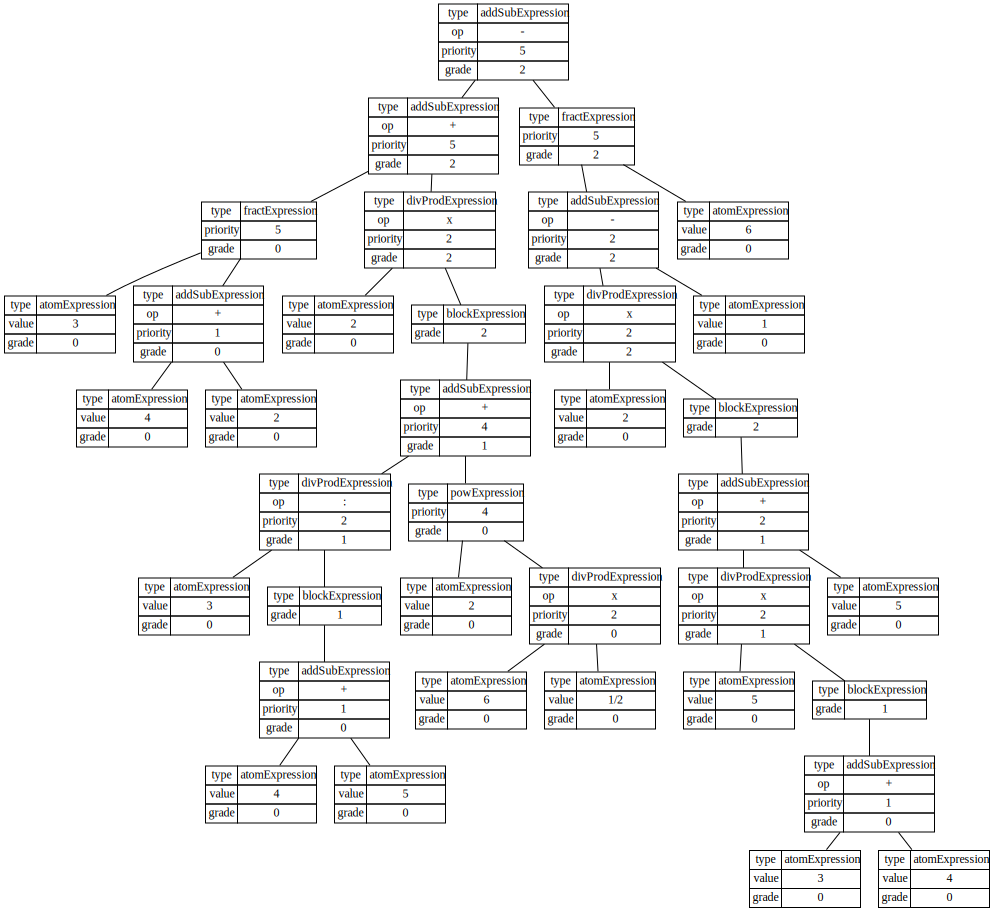

----------------------------------------------------------------------------------------------------


1

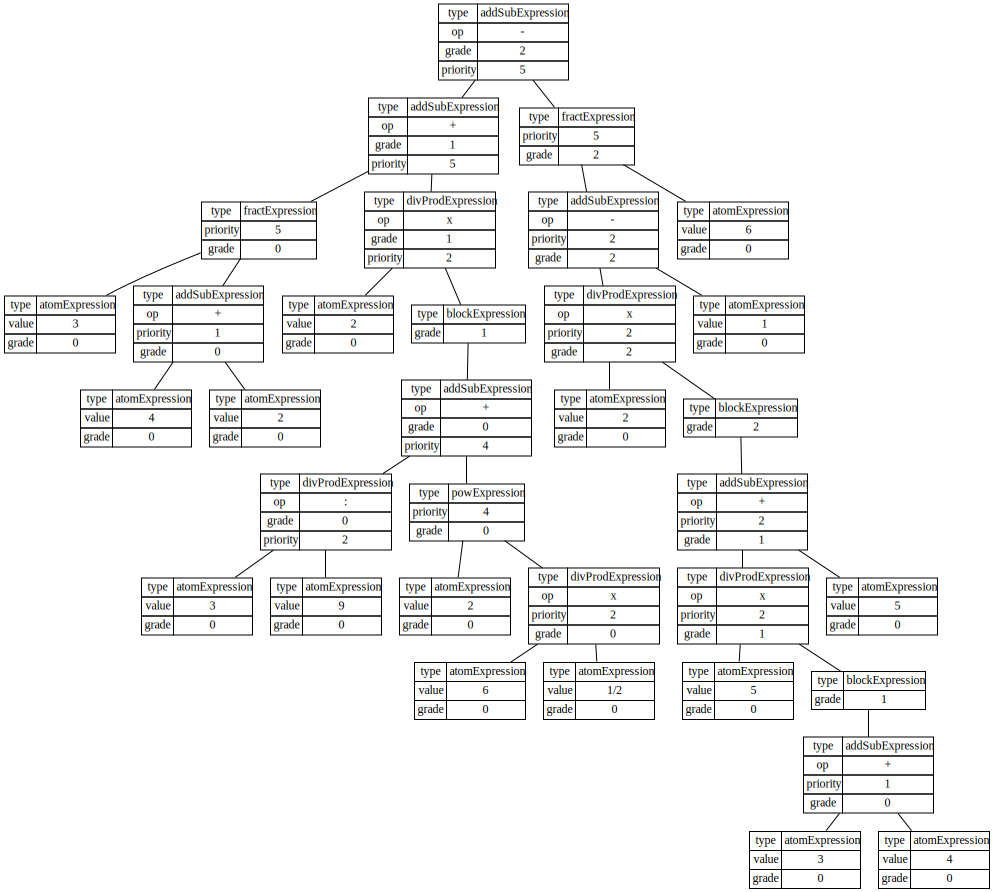

----------------------------------------------------------------------------------------------------


2

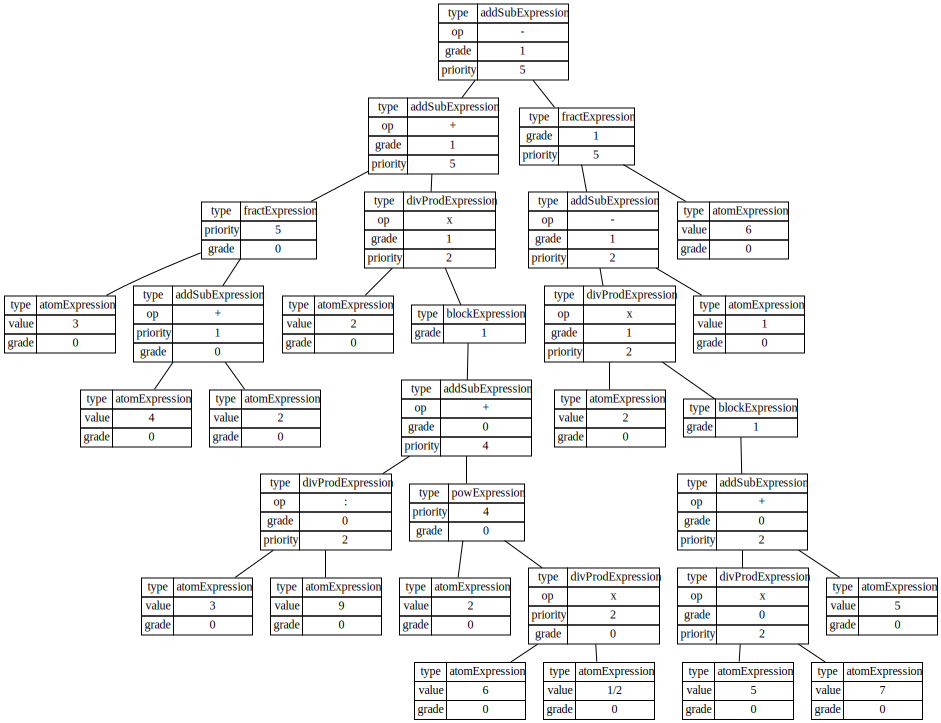

----------------------------------------------------------------------------------------------------


3

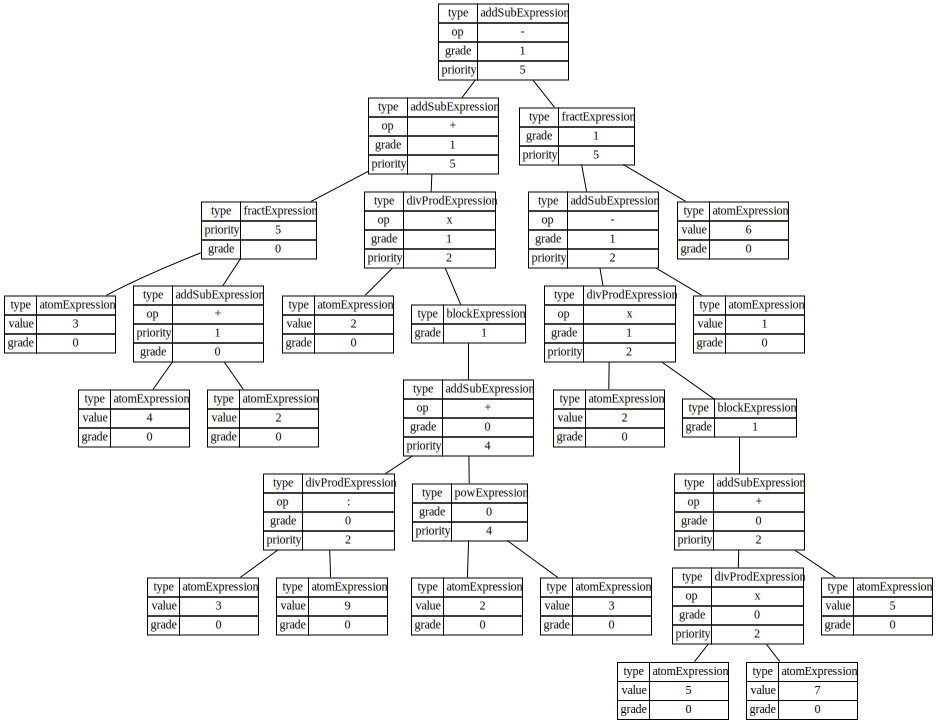

----------------------------------------------------------------------------------------------------


4

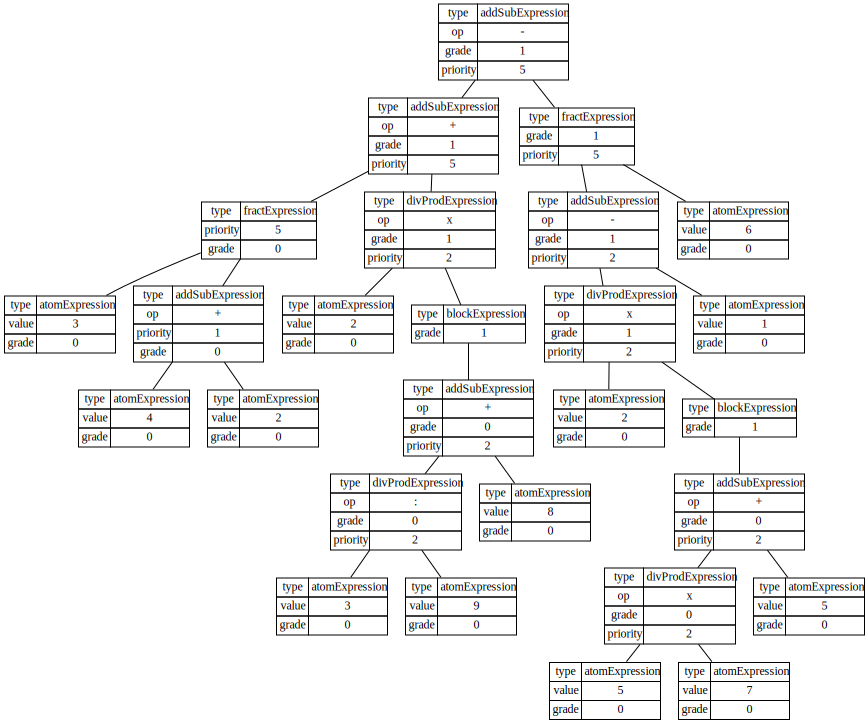

----------------------------------------------------------------------------------------------------


5

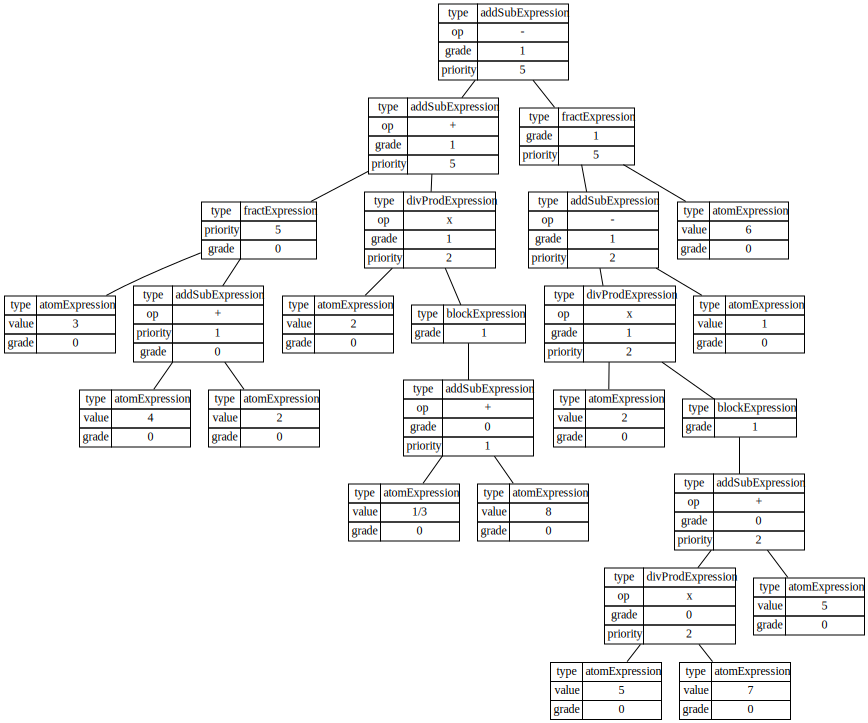

----------------------------------------------------------------------------------------------------


6

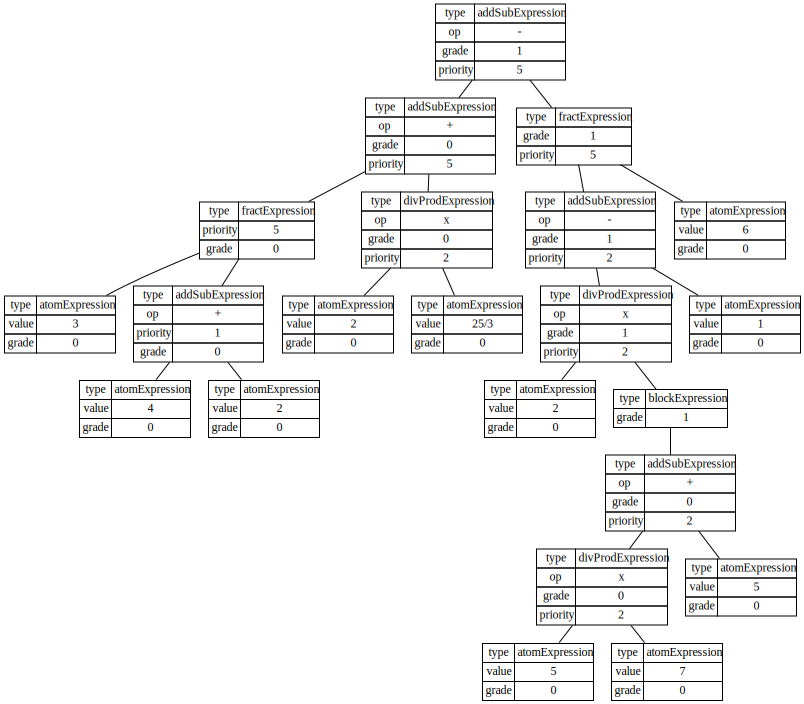

----------------------------------------------------------------------------------------------------


7

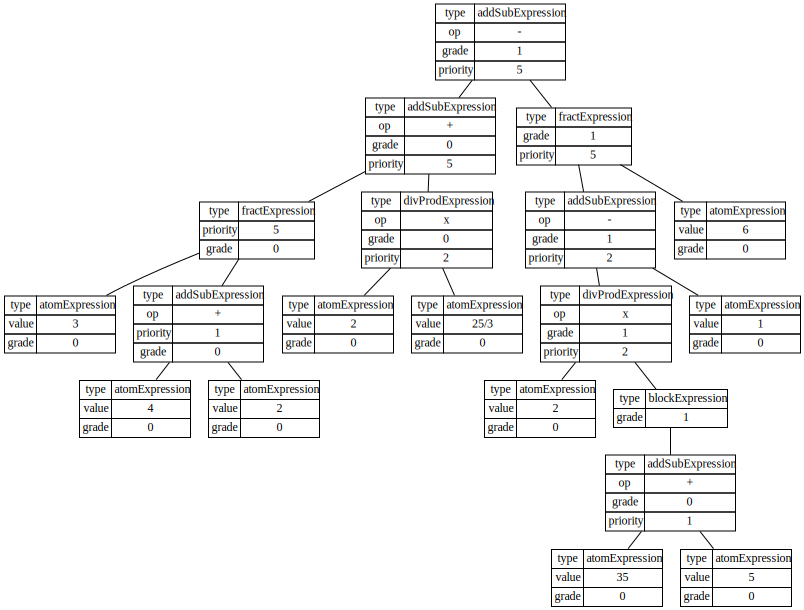

----------------------------------------------------------------------------------------------------


8

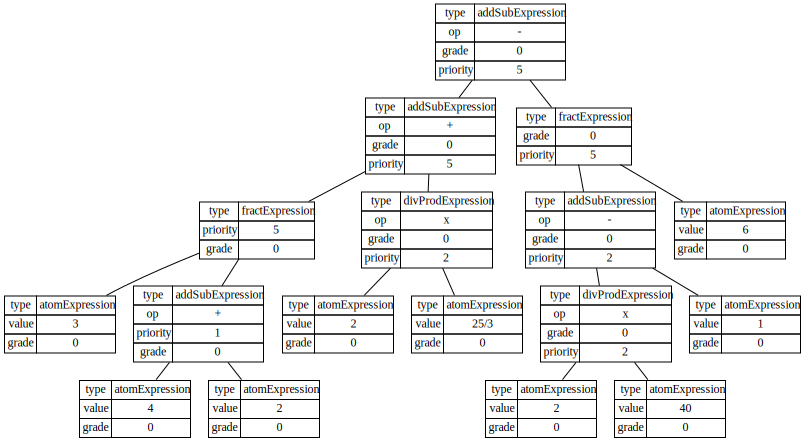

----------------------------------------------------------------------------------------------------


9

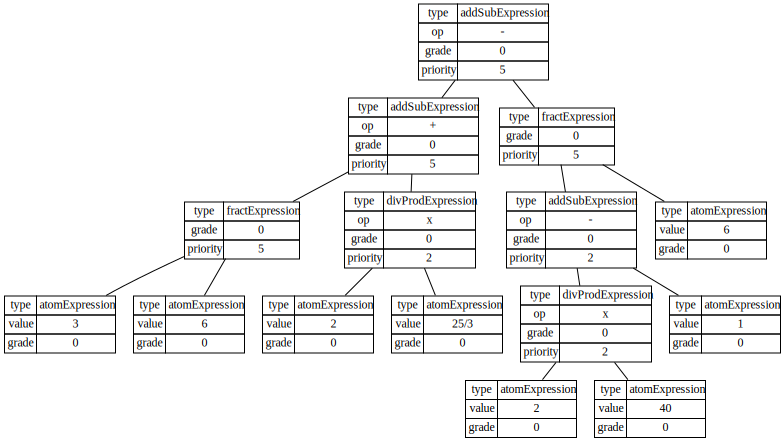

----------------------------------------------------------------------------------------------------


10

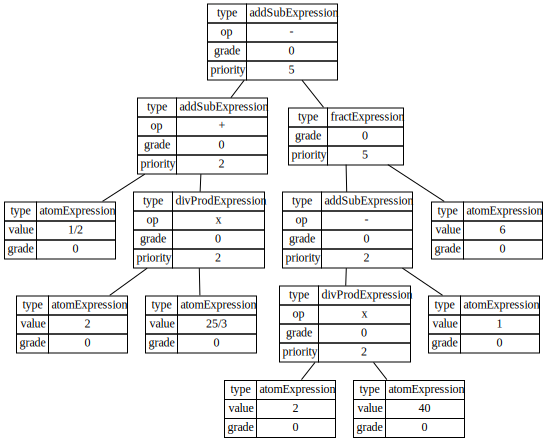

----------------------------------------------------------------------------------------------------


11

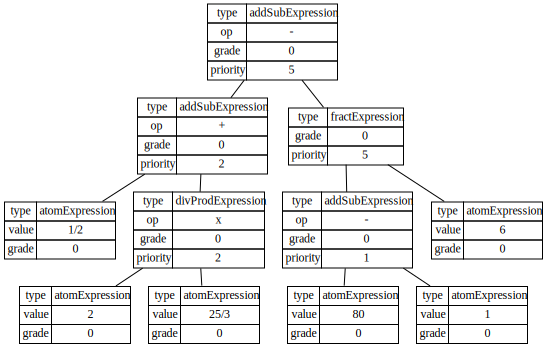

----------------------------------------------------------------------------------------------------


12

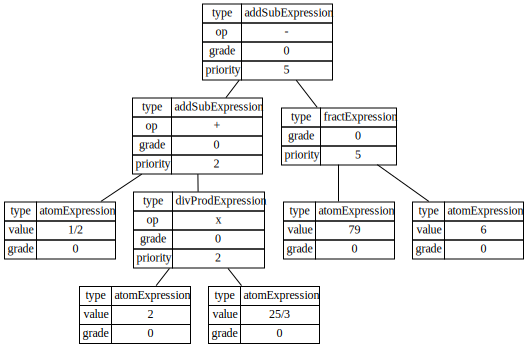

----------------------------------------------------------------------------------------------------


13

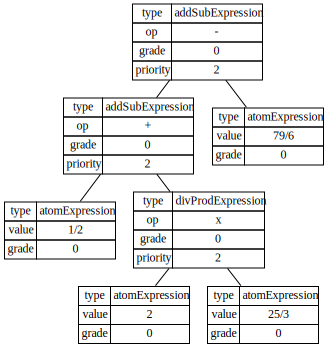

----------------------------------------------------------------------------------------------------


14

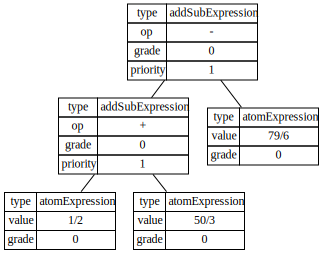

----------------------------------------------------------------------------------------------------


15

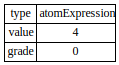

In [259]:
expr = '1 x 8 x 7 x (8 + 7) + (9 x 7 + 8 - (3 + 2+ 3))) - (8 + 9 + 8 + (4))'
ex1 = '1 + (2 x ((3 + 4 : 2) + 5) x 6) - (7 + (1 + 8) : 3) x(9 : (2 + 1) +2)'
ex2 = '<2+3>/4/<5+6>/7'
ex3 = '2^<3+4^5:2^7>'
ex4 = '3 + 13 x <1 + 3>/<2^<1+4> - 6>'
ex5 = '3 / < 4 + 2 > + 2 x ( 3 : ( 4 + 5 ) + 2 ^ < 6 x 1/2 > ) - < 2 x ( 5 x ( 3 + 4 ) + 5 ) - 1 > / 6'
#expr = ex1
expr = ex5

ast = src2ast(expr)
#step(ast)
#step(ast)
count = 0
while ast.children:
    display(count, ast)
    ast = step(ast)
    count += 1
    print('-' * 100)


display(count, ast)


In [ ]:
atw_printer = AnnotatedTreeWalker('type')